# Astrocyte ion homeostasis model (v1)

Single-compartment model of Na⁺/K⁺/Cl⁻/Ca²⁺ dynamics in an astrocyte, based on Ullah lab models (Thapaliya et al. 2023; Meyer et al. 2025).


# Imports and parameters

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

params ={
    'Faraday': 96485.0,
    'VR': 0.33,
    'v_T': 26.6995,#mV
    'G_na':171.6117, # uMmV^-1s^-1 #calibrated value (original value taken from paper: 226.94)
    'G_NKCC':9.568,# uMmV^-1s^-1
    'G_NBC': 130.74, # uMmV^-1s^-1
    'G_NHE': 131, # uMmV^-1s^-1
    'G_k': 8285.7902, #uMmV^-1s^-1 #calibrated value (original value taken from paper: 6907.77)
    'G_KCC1':1.728, #uMmV^-1s^-1
    'G_Cl': 151.93, #uMmV^-1s^-1
    'G_TRPV4': 0.000317, # µM/(mV*s)
    'v': -88.79, #mV
    'pH_o': 7.35,
    'pH_i': 7.33,
    'pKa': 6.1,
    's': 0.225 , #μMPa^-1
    'P_CO2': 5332.9, #Pa
    'k_h': 0.8, #uM
    'rho_conv':13605.0765, # Conversion
    'I_NCX_max': 0.001, # pAuM^-2
    'K_NCX_mN': 87500 , #uM
    'K_NCX_mC': 1380 , #uM
    'eta_NCX':0.35 , #unitless
    'k_sat': 0.1, #unitless
    'K_GluT_mN':15000, #uM
    'K_GluT_mK': 5000, #uM
    'K_GluT_mg': 34, #uM
    'I_GluT_max':0.1, #pAum^-2
    'Vol_a':168, #um^-3
    'Na_bath': 149200, #uM
    'Na_diff': 50, #s^-1
    'K_bath': 2934.0, #uM
    'K_diff': 50, # s^-1
    'Na_a':18730, #uM
    'Na_o':149200,# uM
    'K_a': 92680, #uM
    'K_o': 2934, #uM
    'Cl_a':8215.0, #uM
    'Cl_o':149200 + 2934, #uM
    'Ca_a':0.082, #uM
    'Ca_o':2000, #uM
    'I_pump_max':28400.4,#uMs^-1
    'KNaK_simple': 10000,# μM
    'KKs_simple': 1500 # μM
}


HCO3_o = (10**(params['pH_o']-params['pKa']))*params['s']*params['P_CO2']
HCO3_a = (10**(params['pH_i']-params['pH_o']))*HCO3_o

H_o= (params['s']*params['k_h']*params['P_CO2'])/HCO3_o
H_a= (params['s']*params['k_h']*params['P_CO2'])/HCO3_a




# Helper Functions

In [ ]:
def hill(l,k,n):
  h = (l**n)/(l**n + k**n)
  return h

def nernst(Con_out, Con_in, z):

  eps = 1e-9 # Ensure non-negative
  Con_out = max(Con_out, eps)
  Con_in = max(Con_in, eps)
  return (params['v_T']/ z) * np.log(Con_out / Con_in)

def nernst_NBC(Na_o, Na_a, HCO3_o, HCO3_a, params):

  eps = 1e-9 # Ensure non-negative
  Na_o = max(Na_o, eps)
  Na_a = max(Na_a, eps)
  HCO3_o = max(HCO3_o, eps)
  HCO3_a = max(HCO3_a, eps)
  return (-params['v_T']*np.log((Na_o*(HCO3_o**2)) / (Na_a*(HCO3_a**2))))

def nernst_NHE(Na_o, Na_a, H_o, H_a, params):

  eps = 1e-9 # Ensure non-negative
  Na_o = max(Na_o, eps)
  Na_a = max(Na_a, eps)
  H_o = max(H_o, eps)
  H_a = max(H_a, eps)
  return  params['v_T']*np.log((Na_o*H_o) / (Na_a*H_a))

# ODE system definition

In [ ]:
#Calcium fluxes are not added yet

def J_Na(Na_a, Na_o, v, params):
  E_na = nernst(Na_o, Na_a, 1)
  J_Na = params['G_na']*(v-E_na)
  return J_Na

def J_K(K_a, K_o, v, params):
  E_k = nernst(K_o, K_a, 1)
  return params['G_k'] * (v - E_k)

def J_Cl(Cl_a, Cl_o,v, params):
  E_cl = nernst(Cl_o,Cl_a, -1)
  return params['G_Cl']*(v - E_cl)

def J_NaK(Na_a, K_o, params):

  JNaKmax = params['I_pump_max']
  KNaK = params['KNaK_simple']
  KKs = params['KKs_simple']
  J_pump = JNaKmax * (Na_a**1.5) / (Na_a**1.5 + KNaK**1.5) * (K_o / (K_o + KKs))
  return J_pump

def J_NKCC(Na_a, K_a, Cl_a, Na_o, K_o,Cl_o, params):
  J_NKCC = params['G_NKCC']*params['v_T']*np.log((Na_o*K_o*(Cl_o)**2)/(Na_a*K_a*(Cl_a)**2))
  return J_NKCC

def J_NCX(Na_a, Na_o,v,params):
  H_Na = hill(Na_o, params['K_NCX_mN'], 3)
  H_Ca = hill(params['Ca_o'], params['K_NCX_mC'], 1)
  expression1 = np.exp(params['eta_NCX'] * (v / params['v_T']))
  expression2 = np.exp((params['eta_NCX'] - 1.0) * (v / params['v_T']))
  numerator = ((Na_a**3)/(Na_o**3) )*expression1 - ((params['Ca_a']/params['Ca_o'])*expression2 )
  denominator = 1.0 + params['k_sat']*expression2
  return (params['I_NCX_max'] * H_Na * H_Ca * (numerator/denominator))*5000

def J_GluT(Na_o, K_a, Glu, params):
  H_Na = hill(Na_o, params['K_GluT_mN'], 3)
  H_K = hill(K_a, params['K_GluT_mK'], 1)
  H_g = hill(Glu, params['K_GluT_mg'], 1)
  J_Glut = params['I_GluT_max']*H_Na*H_K*H_g
  return J_Glut

def J_NBC(Na_a, Na_o, v, params):
  E_NBC = nernst_NBC(Na_o, Na_a, HCO3_o, HCO3_a, params)
  J_NBC = params['G_NBC'] * (v - E_NBC)
  return J_NBC

def J_NHE(Na_a, Na_o, v, params):
  E_NHE = nernst_NHE(Na_o, Na_a, H_o, H_a, params)
  J_NHE= params['G_NHE'] * (v - E_NHE)
  return J_NHE

def J_KCC1(K_a,Cl_a, K_o, Cl_o, params):
  J_KCC1 = (params['G_KCC1']*params['v_T'])*np.log((K_o*Cl_o)/(K_a*Cl_a))
  return J_KCC1

def calculate_voltage_change(I_na, I_k, I_cl, I_pump, I_nbc, I_nhe, I_ncx, I_glut, params):
    electrogenic_current = (-I_na - I_k - I_cl - I_pump + I_nbc - I_nhe - I_ncx + 2*I_glut)
    dV_dt = params['rho_conv'] * electrogenic_current
    return dV_dt


In [ ]:
# #Simple glutamate pulse
# def Glu_t_realistic(t, Glu_peak=1000, t_release=50, tau_decay=4):
#     """
#     Exponential decay model for glutamate
#     Glu_peak: peak concentration (μM)
#     t_release: time of release (s)
#     tau_decay: decay time constant (s):  how fast it clears; smaller tau decay, faster it clears
#     """
#     if t < t_release:
#         return 0.0
#     else:
#         return Glu_peak * np.exp(-(t - t_release) / tau_decay)

In [ ]:
#Multiple pulses (amount of pulses can be adjusted)

def Glu_t_realistic(t, Glu_peak=[200,400,800,1000],  t_release=[50, 75, 100, 125], tau_decay=4):
    """
    Exponential decay model for glutamate that supports multiple pulses (change this in the argument, Glu_peak=[],  t_release=[]).

    t : float
        Current time (s).
    Glu_peak : float or list of floats
        Peak concentration (µM). If scalar, applies to all releases.
    t_release : float or list of floats
        Time(s) of release events.
    tau_decay : float
        Decay time constant (s).
    """
    # Normalize inputs to lists
    if np.isscalar(t_release):
        releases = [t_release]
    else:
        releases = t_release

    if np.isscalar(Glu_peak):
        peaks = [Glu_peak] * len(releases)
    else:
        peaks = Glu_peak

    # Calculate sum of all pulses
    total_glu = 0.0
    # zip stops at the shortest list length. If peaks is shorter than releases, extra releases are ignored.
    for tr, peak in zip(releases, peaks):
        if t >= tr:
            total_glu += peak * np.exp(-(t - tr) / tau_decay)

    return total_glu

# #Code to calibrate/test by turning off glutamate, uncomment if needed:
# def Glu_t_realistic(t, Glu_peak=1000.0, t_release=50, tau_decay=4):
#     return 0.0



In [ ]:
# #Calibration procedure (no need to run this)

# def calibrate_conductances(params):
#     Na_a, Na_o = params['Na_a'], params['Na_o']
#     K_a, K_o = params['K_a'], params['K_o']
#     Cl_a, Cl_o = params['Cl_a'], params['Cl_o']
#     Glu = 0  # no glutamate

#     # Calculate all active fluxes
#     j_pump = J_NaK(Na_a, K_o, params)
#     j_nkcc = J_NKCC(Na_a, K_a, Cl_a, Na_o, K_o, Cl_o, params)
#     j_nbc = J_NBC(Na_a, Na_o, params['v'], params)
#     j_nhe = J_NHE(Na_a, Na_o,params['v'], params)
#     j_ncx = J_NCX(Na_a, Na_o,params['v'], params)
#     j_glut = J_GluT(Na_o, K_a, Glu, params)
#     j_kcc1 = J_KCC1(K_a, Cl_a, K_o, Cl_o, params)
#     conv = params['rho_conv']

#     # Solver for G_na
#     Sum_Active_Na = -3*j_pump + j_nkcc + j_nbc - j_nhe - (3*j_ncx - 3*j_glut)*conv
#     E_na = nernst(Na_o, Na_a, 1)
#     new_G_na = Sum_Active_Na / (params['v'] - E_na)

#     # Solver for G_k
#     Sum_Active_K = 2*j_pump + j_nkcc + j_kcc1 - j_glut*params['rho_conv']
#     E_k = nernst(K_o, K_a, 1)
#     new_G_k = Sum_Active_K / (params['v'] - E_k)

#     return new_G_na, new_G_k

# # Execute calibration
# calibrated_G_na, calibrated_G_k = calibrate_conductances(params)
# print(f"Calibrated G_na: {calibrated_G_na}")
# print(f"Calibrated G_k: {calibrated_G_k}")

# Dynamics setup

In [ ]:
#Only sodium dynamics

def astrocite_na_dynamics(y,t,params):
  Na_a, Na_o= y

  # Ensure non-negative
  eps = 1e-9
  Na_a = max(Na_a, eps)
  Na_o = max(Na_o, eps)

  # Glutamate stimulus
  Glu = Glu_t_realistic(t)
  # Calculate all fluxes

  Jna   = J_Na(Na_a, Na_o, params['v'], params)
  Jnak  = J_NaK(Na_a, params['K_o'], params)
  Jnkcc = J_NKCC(Na_a,params['K_a'],params['Cl_a'], Na_o, params['K_o'], params['Cl_o'], params)
  Jnbc  = J_NBC(Na_a, Na_o, params['v'],  params)
  Jnhe  = J_NHE(Na_a, Na_o, params['v'],  params)
  Jncx = J_NCX(Na_a, Na_o, params['v'], params)
  Jglut = J_GluT(Na_o, params['K_a'], Glu, params)


  dNa_a_dt =  -Jna - 3*Jnak + Jnkcc +Jnbc - Jnhe - (3*Jncx - 3*Jglut)*params['rho_conv']

  dNa_o_dt = params['VR']*(Jna + 3*Jnak - Jnkcc -Jnbc  + Jnhe - (-3*Jncx + 3*Jglut)*params['rho_conv'])
  dNa_o_dt += params['Na_diff'] * (params['Na_bath'] - Na_o)  # bath term (µM/s)


  return dNa_a_dt, dNa_o_dt


In [ ]:
def astrocite_full_dynamics(y, t, params):
    Na_a, Na_o, K_a, K_o, Cl_a, Cl_o, v = y

    # Ensure non-negative
    eps = 1e-9
    Na_a = max(Na_a, eps)
    Na_o = max(Na_o, eps)
    K_a = max(K_a, eps)
    K_o = max(K_o, eps)
    Cl_a = max(Cl_a, eps)
    Cl_o = max(Cl_o, eps)

    # Glutamate stimulus
    Glu = Glu_t_realistic(t)

    # Calculate all fluxes
    Jna = J_Na(Na_a, Na_o, v, params)
    Jk = J_K(K_a, K_o,v, params)
    Jcl= J_Cl(Cl_a, Cl_o,v, params)
    Jnak = J_NaK(Na_a, K_o, params)
    Jnkcc = J_NKCC(Na_a, K_a, Cl_a, Na_o, K_o,Cl_o, params)

    Jkcc1 = J_KCC1(K_a,Cl_a, K_o, Cl_o, params)

    Jnbc = J_NBC(Na_a, Na_o, v, params)
    Jnhe = J_NHE(Na_a, Na_o,v, params)
    Jncx = J_NCX(Na_a, Na_o, v, params)
    Jglut = J_GluT(Na_o, K_a, Glu, params)

    conv = params['rho_conv']

    dNa_a_dt =  -Jna - 3*Jnak + Jnkcc +Jnbc - Jnhe - (3*Jncx - 3*Jglut)*conv
    dNa_o_dt = params['VR']*(Jna + 3*Jnak - Jnkcc -Jnbc  + Jnhe - (-3*Jncx + 3*Jglut)*conv)
    dNa_o_dt += params['Na_diff'] * (params['Na_bath'] - Na_o)  # bath term (µM/s)

    dK_a_dt = -Jk + 2*Jnak + Jnkcc + Jkcc1 - Jglut*conv
    dK_o_dt = params['VR']*(Jk - 2*Jnak - Jnkcc - Jkcc1 + Jglut*conv)
    dK_o_dt += params['K_diff'] * (params['K_bath'] - K_o)  # bath term (µM/s)

    # Cl⁻ from electroneutrality:
    dCl_a_dt = dNa_a_dt + dK_a_dt  # simplified, ignoring Ca²⁺ for now;
    dCl_o_dt = dNa_o_dt + dK_o_dt

    dV_dt = calculate_voltage_change(Jna, Jk, Jcl, Jnak, Jnbc, Jnhe,
                                 Jncx, Jglut, params)

    return dNa_a_dt, dNa_o_dt, dK_a_dt, dK_o_dt, dCl_a_dt, dCl_o_dt, dV_dt

# Simulation 1: only sodium dynamics + glutamate pulse + audit terms

In [ ]:
t = np.linspace(0, 150, 150_001)  # 0 to 150 seconds # so the timestep is 0.001 seconds

# Initial conditions
y0 = [params['Na_a'], params['Na_o']]

# Solve ODE
solution = odeint(astrocite_na_dynamics, y0, t, args=(params,))

# Extract results
Na_a_solution = solution[:, 0]
Na_o_solution = solution[:, 1]



In [ ]:
def audit_terms(Na_a, Na_o, t, p):
    Glu   = Glu_t_realistic(t)
    I_leak = J_Na(Na_a, Na_o,p['v'], p)
    I_pump = J_NaK(Na_a, p['K_o'], p)
    I_nkcc = J_NKCC(Na_a,params['K_a'],params['Cl_a'], Na_o, params['K_o'], params['Cl_o'], p)
    I_nbc  = J_NBC(Na_a, Na_o,p['v'],p)
    I_nhe  = J_NHE(Na_a, Na_o, p['v'],p)
    I_ncx  = J_NCX(Na_a, Na_o, p['v'], p)
    I_glut = J_GluT(Na_o, p['K_a'], Glu, p)
    conv   = p['rho_conv']
    dNa_i  = (-I_leak - 3*I_pump + I_nkcc + I_nbc - I_nhe
              -3*I_ncx*conv + 3*I_glut*conv)
    print(f"[audit t={t:.3f}s] μM/s terms:",
          {'-leak':-I_leak,'-3*pump':-3*I_pump,'+nkcc':I_nkcc,'+nbc':I_nbc,
           '-nhe':-I_nhe,'-3*ncx':-3*I_ncx*conv,'+3*glut':3*I_glut*conv,
           'SUM dNa_i': dNa_i})


t_checks = [0, 50.2, 150]
for tc in t_checks:
    k = np.searchsorted(t, tc)
    Na_a, Na_o = solution[k, 0], solution[k, 1]
    audit_terms(Na_a, Na_o, t[k], params)


[audit t=0.000s] μM/s terms: {'-leak': np.float64(24745.680483461358), '-3*pump': np.float64(-40556.38251669047), '+nkcc': np.float64(1139.3488710677834), '+nbc': np.float64(-4043.150120670749), '-nhe': np.float64(18728.573284638253), '-3*ncx': np.float64(-14.0724541904003), '+3*glut': np.float64(0.0), 'SUM dNa_i': np.float64(-0.002452384227787263)}
[audit t=50.200s] μM/s terms: {'-leak': np.float64(24608.410864015485), '-3*pump': np.float64(-41060.92370075776), '+nkcc': np.float64(1131.695571678184), '+nbc': np.float64(-4147.727081602627), '-nhe': np.float64(18623.78835361426), '-3*ncx': np.float64(-17.19570022186786), '+3*glut': np.float64(3282.102700328606), 'SUM dNa_i': np.float64(2420.1510070542795)}
[audit t=150.000s] μM/s terms: {'-leak': np.float64(24706.788005486007), '-3*pump': np.float64(-40700.91869980705), '+nkcc': np.float64(1137.180468626294), '+nbc': np.float64(-4072.779817075465), '-nhe': np.float64(18698.884664254147), '-3*ncx': np.float64(-14.929325249663506), '+3*gl

In [ ]:
# Drift analysis

drift_uM = solution[-1, 0] - solution[0, 0]
drift_mM = drift_uM / 1000.0 # mM

print(f"\nInitial Na_a: {solution[0,0]/1000:.2f} mM")
print(f"Final Na_a:   {solution[-1,0]/1000:.2f} mM")
print(f"Drift:        {drift_mM:+.3f} mM over 150s")


Initial Na_a: 18.73 mM
Final Na_a:   18.89 mM
Drift:        +0.160 mM over 150s


# Simulation 2: sodium, potassium and chlorine dynamics (november 29th) + glutamate pulse

In [ ]:
#Calcium dynamics are not added yet

t = np.linspace(0, 150, 150_001)  # 0 to 150 seconds # so the timestep is 0.001 seconds

# Initial conditions
y0 = [params['Na_a'], params['Na_o'],
      params['K_a'], params['K_o'],
      params['Cl_a'], params['Cl_o'], params['v']]

# Solve ODE
solution = odeint(astrocite_full_dynamics, y0, t, args=(params,))

# Extract results
Na_a_sol = solution[:, 0]
Na_o_sol = solution[:, 1]
K_a_sol = solution[:, 2]
K_o_sol = solution[:, 3]
Cl_a_sol = solution[:, 4]
Cl_o_sol = solution[:, 5]
V_sol = solution[:,6]


In [ ]:
# Drift analysis
for ion_name, conc in [('Na_a', Na_a_sol), ('Na_o', Na_o_sol),
                        ('K_a', K_a_sol), ('K_o', K_o_sol),
                        ('Cl_a', Cl_a_sol), ('Cl_o', Cl_o_sol)]:
    initial = conc[0] / 1000  # mM
    final = conc[-1] / 1000   # mM
    drift = final - initial
    print(f"{ion_name:6s}: {initial:7.2f} → {final:7.2f} mM  (Drift: {drift:+.3f} mM)")

Na_a  :   18.73 →   18.87 mM  (Drift: +0.143 mM)
Na_o  :  149.20 →  149.20 mM  (Drift: +0.000 mM)
K_a   :   92.68 →   93.85 mM  (Drift: +1.165 mM)
K_o   :    2.93 →    2.93 mM  (Drift: +0.000 mM)
Cl_a  :    8.21 →    9.52 mM  (Drift: +1.309 mM)
Cl_o  :  152.13 →  152.13 mM  (Drift: +0.001 mM)


# Plotting results

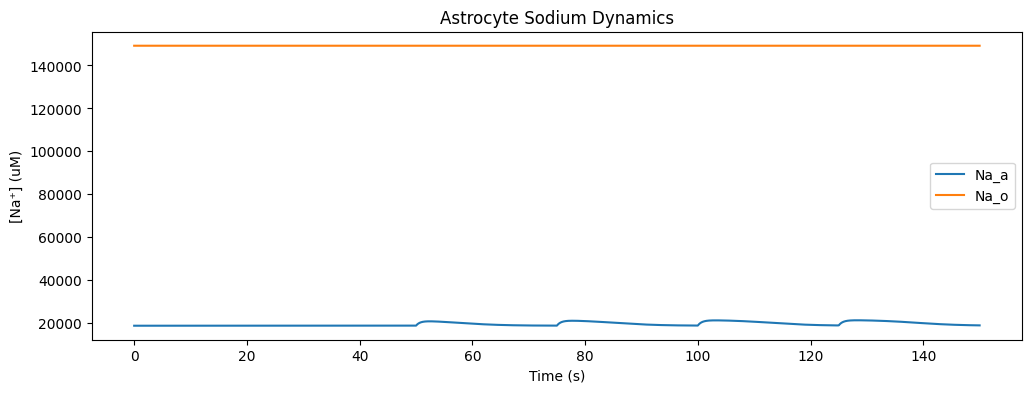

In [ ]:
#Plot for sodium only dynamics
plt.figure(figsize=(12, 4))
plt.plot(t, Na_a_solution, label='Na_a')
plt.plot(t, Na_o_solution, label='Na_o')
plt.xlabel('Time (s)')
plt.ylabel('[Na⁺] (uM)')
plt.title('Astrocyte Sodium Dynamics')
plt.legend()
plt.show()



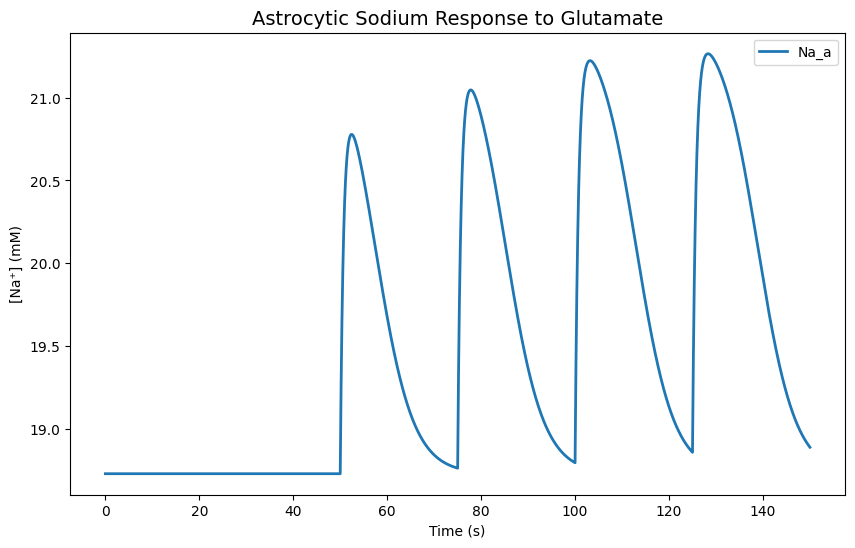

In [ ]:
#Astrocytic sodium trajectory in sodium only dynamics
plt.figure(figsize=(10, 6))
plt.plot(t, Na_a_solution/1000, label='Na_a', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('[Na⁺] (mM)')
plt.title('Astrocytic Sodium Response to Glutamate', fontsize=14)
plt.legend()
plt.show()

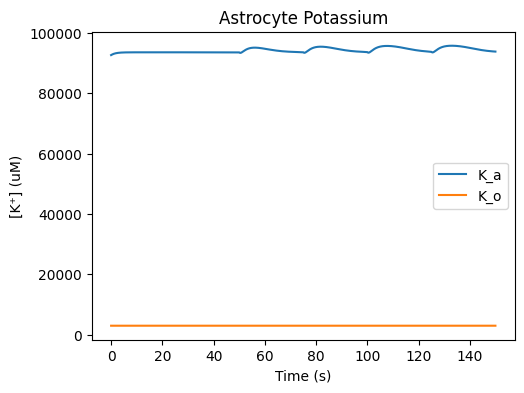

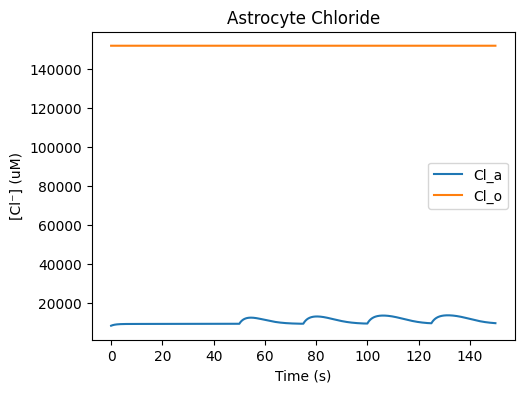

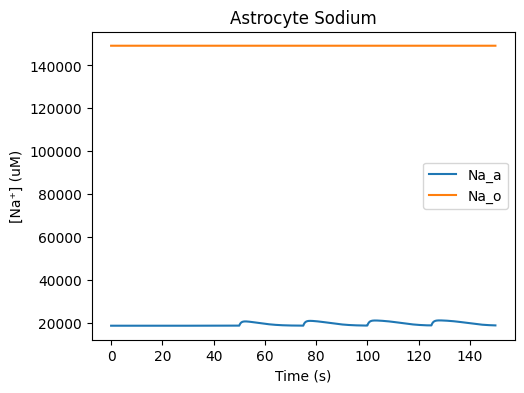

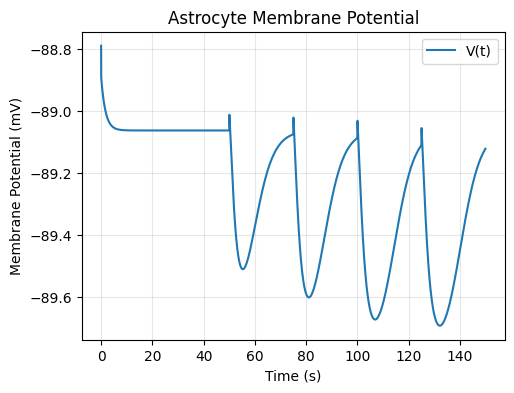

In [ ]:
#Plots for full dynamics

#Potassium (outside and inside) dynamics over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, K_a_sol, label='K_a')
plt.plot(t, K_o_sol, label='K_o')
plt.xlabel('Time (s)')
plt.ylabel( '[K⁺] (uM)')
plt.title('Astrocyte Potassium')
plt.legend()
plt.show()

#Chloride (outside and inside) dynamics over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, Cl_a_sol, label='Cl_a')
plt.plot(t, Cl_o_sol, label='Cl_o')
plt.xlabel('Time (s)')
plt.ylabel('[Cl⁻] (uM)')
plt.title('Astrocyte Chloride')
plt.legend()
plt.show()

#Sodium (outside and inside) dynamics over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, Na_a_sol, label='Na_a')
plt.plot(t, Na_o_sol, label='Na_o')
plt.xlabel('Time (s)')
plt.ylabel('[Na⁺] (uM)')
plt.title('Astrocyte Sodium')
plt.legend()
plt.show()

#Voltage over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, V_sol, label='V(t)')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Astrocyte Membrane Potential')
plt.legend()
plt.grid(alpha=0.3)


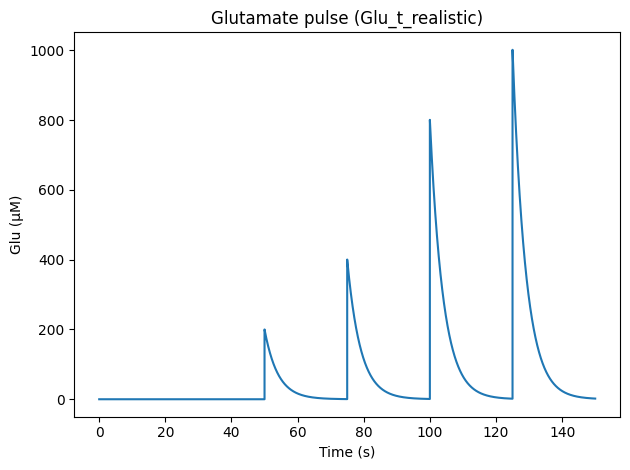

In [ ]:
# Plot for glutamate pulse

G = np.array([Glu_t_realistic(t) for t in t])
plt.figure()
plt.plot(t, G)
plt.xlabel('Time (s)')
plt.ylabel('Glu (µM)')
plt.title('Glutamate pulse (Glu_t_realistic)')
plt.tight_layout()

# Notes and next steps

**Model status (v1)**  
- This version is the first version of my mini project to implement astrocyte ion dynamics and glutamate flux.  
- Fluxes currently include: leaks, Na⁺/K⁺-ATPase (NKA), NKCC, KCC1, NBC, NHE, NCX, and Na⁺-dependent glutamate transporters.  
- Parameters and flux forms are adapted from Ullah lab models (Thapaliya et al., 2023; Meyer et al., 2025).  
- Simulations here focus on baseline behavior and simple parameter sweeps to check drift and steady states and relation to glutamate fluxes.

**Limitations of this version**  
- No explicit NMDA or AMPA receptor-mediated currents yet (based on paper).  
- Calcium dynamics are not added yet
- Astrocyte is treated as a single well-mixed compartment (no soma versus processes, no spatial gradients).  
- Parameters are not yet systematically fit to specific experiments; they are taken directly or slightly adjusted from the source papers.

**Planned next steps**  
- Add NMDA and AMPA receptor fluxes to model glutamate-evoked Na⁺/Ca²⁺ entry.
- Add calicum-related fluxes and calcium dynamics
- Split the model into soma and process compartments to study local Na⁺ microdomains and explore how differences in local Na⁺ and distance between soma and processes affect glutamate uptake and K⁺ handling.  
- Connect this astrocyte model to simple neuron models to study how ion homeostasis influences network stability and memory-related activity.